In [1]:
import numpy as np
import toml
import Dans_Diffraction

In [2]:
with open(f'lens_files/id06.lens') as f:
    lens_file_contents = f.read()
print(lens_file_contents)

# lens configuration file for https://github.com/trygvrad/DF-XRM_viz, read as a .toml file

# The example is for the id06 beamline at the ESRF.
# The lensbox consists of 88 Be lenses with a 50 µm radius of curvature. 
# The first 68 lenses are spaced 1.6 mm apart, the remaining 20 lenses are spaced 2 mm apart


# The center of the first lens defines position 0, and and the series ends at the center of the final lens. 
# The total length of the series is (number_of_lenses-1)*lens_spacing_in_mm.
# There is a maximum of 100 lens series numbered 0 to 99, with separators in between
[lens_series_0]
	radius_of_curvature_in_µm = 50 
	number_of_lenses = 68
	lens_spacing_in_mm = 1.6 	
[lens_series_0.material]
	# from http://www.crystallography.net/cod/9008488.cif
	atoms_in_Unit_cell = ["Be", "Be"] 
	unit_cell_volume_in_AA3 = 16.225

# A separator between the first and second series of lenses 
[separator_0]
	spacing_in_mm = 2

[lens_series_1]
	radius_of_curvature_in_µm = 50 
	number_of_lenses = 2

In [3]:
def align_optics_from_config(parsed_lens_file, energy_kev):
    '''
    Gets the focal lenght of each lenselet and the distances between lenslets from the lens(toml) file.
    Settings in the parsed_lens_file are deleted as used (in place)
    input:
        parsed_lens_file: loaded lens(toml) file (i.e. dictionary of dictionaries) 
        energy_kev: float
    return:
        focal_lengths: list of length equal to the number of lenslets containing their focal length
        interlens_distances: list of distances between lenselents, the length is len(focal_lengths)-1
    '''
    focal_lengths = [] # <- focal lengths of lenses
    distances = [] # <- lens position from start of lensbox
    distance_so_far_in_mm = 0
    for i in range(100):
        # check if we have a lens series
        series_name = f'lens_series_{i}'
        if series_name in parsed_lens_file:
            lens_series = parsed_lens_file[series_name]
            n_comlex = Dans_Diffraction.fc.xray_refractive_index(\
                                     lens_series['material']['atoms_in_Unit_cell'],
                                     energy_kev, 
                                     1.0/lens_series['material']["unit_cell_volume_in_AA3"])[0]
            R = lens_series['radius_of_curvature_in_µm']/1000 # x µm curvature
            n = n_comlex.real
            δ = 1-n
            f = R/(2*δ)
            for _ in range(lens_series['number_of_lenses']):
                focal_lengths.append(f)
                distances.append(distance_so_far_in_mm)
                distance_so_far_in_mm += lens_series['lens_spacing_in_mm']
            distance_so_far_in_mm -= lens_series['lens_spacing_in_mm'] # remove last shift
            del lens_series['radius_of_curvature_in_µm'], lens_series['number_of_lenses'], lens_series['lens_spacing_in_mm']
            del lens_series['material']['atoms_in_Unit_cell'], lens_series['material']['unit_cell_volume_in_AA3']
            if len(lens_series['material']) == 0:
                del lens_series['material']
            if len(lens_series) == 0:
                del parsed_lens_file[series_name]
        # check if we have a separator
        separator_name = f'separator_{i}'
        if separator_name in parsed_lens_file:
            separator = parsed_lens_file[separator_name]
            distance_so_far_in_mm += separator['spacing_in_mm']
            del separator['spacing_in_mm']
            if len(separator) == 0:
                del parsed_lens_file[separator_name]

    interlens_distances = np.array(distances[1:])-np.array(distances[:-1])
    return focal_lengths, interlens_distances


def get_dn(fs, ds):
    '''
    Consider a sample (s) and a numer of lenses with focusing power f# and distance between
    each optical component (d#) as shown in the drawing below:
    s    d0    f0 d1 f2 d3 f3 d3 f4      dn   D
    x----------)(----)(----)(----)(-----------|
    This function gets distance from last lenslet to the detector (dn) for the image to be in focus at the detector (D)
    input:
        fs: list of floats, describing the thin-lens focusing power of each lenslet
        ds: list of floats, distances between optical components (first element is the sample-lenselet distance, aka d1 in most literature)
    returns:
        float, distance from last lenslet to the detector (dn)
    '''
    d = 0.0 # distance from source
    L = 0.0 # total distance
    for i, f in enumerate(fs):
        d += ds[i]
        L += ds[i]
        d = d*f/(f-d)
    return L-d

def get_d1_d2_from_tot_d(fs, ds, d_tot, initial_guess):
    '''
    Gets both d1 and d2 (distance from sample to lens and from lens to detector) using get_dn for a fixed d_tot
    This function only works with a good initial guess. A suitable guess can be found by setting initial_guess = thin_lens_focal_distance+delta
    where delta is a small number i.e. 1
    input:
        fs: list of floats, describing the thin-lens focusing power of each lenslet
        ds: list of floats [len(ds) == len(fs)-1], distance between each lenslet
        d_tot: float, total distance froms sample to detector
    return:
        d0, dn (floats, distance sample to first lenslet, distance last lenselet to detector)
    '''
    ds = list(ds) # ensure this is list, for easy concaetenation syntax
    dL = np.sum(ds) # total distance in lens box

    def fn(d0):
        ''' 
        The error function for a calculated d0
        i.e. (dtot-(d1+dlens+d2))**2
        '''
        return (d0 + dL + get_dn(fs, [d0]+ds) - d_tot)**2
    
    # visualize the loss curve, initial guess and final refinement (for debugging)
    '''
    fig, ax = plt.subplots()
    xs = np.arange(0,d_tot//2)
    y = [fn(x) for x in xs]
    ax.semilogy(xs,y, color = [0,0.3,1], label = "loss")
    ax.axvline(initial_guess, color = [0,0,0,0.5], label = "initial guess")
    ax.axvline(scipy.optimize.minimize(fn, initial_guess).x[0], color = [1,0.3,0,0.5], label = "final")
    ax.legend()
    '''
    d0 = scipy.optimize.minimize(fn, initial_guess).x[0]
    dn = d_tot-d0-dL
    return d0, dn

def get_magnification(fs,ds):
    '''
    calculates the magnification based on the distance between optical components
    input:
        fs: array-like of length n,   focal distance of each lenselet
        ds: array-like of length n+1, distance between each optical component (source-lenselet, lenselet-lenselet*(n-1), lenselet-detector)
    returns:
        float, magnification
    '''
    height = -1 #mm
    slope = height/-ds[0]
    d = -ds[0] # distance from intersection of height = 0
    for i, _ in enumerate(fs):
        height += slope*ds[i]
        d += ds[i]
        d = d*fs[i]/(fs[i]-d)
        if i>0:
            slope = height/d
        #print(i, slope, height, d)

    height += slope*ds[-1]
    return height # (heightin mm) == (height in mm)/(1 mm) == magnification

In [4]:
import matplotlib.pyplot as plt
import scipy.optimize
import numpy as np



In [5]:

parsed_lens_file = toml.loads(lens_file_contents)
d_tot = 5000
energy_kev = 17
focal_lengths, interlens_distances = align_optics_from_config(parsed_lens_file, energy_kev)

f_tl = 1/np.sum(1/np.array(focal_lengths)) # approximation of thin-lens focal distance

d0, dn = get_d1_d2_from_tot_d(focal_lengths, interlens_distances, d_tot, f_tl)
print(d0)
M = get_magnification(focal_lengths,[d0]+list(interlens_distances)+[dn])
print(M)
# 210


210.72401790076708
16.539078585351877


In [16]:
import imageio
def make_optics_geometry_plot(energy_kev, two_theta, d_tot, parsed_lens_file):
    '''
    Calculates the lens position from the config and annotates the figure 'd1_d2_fig.png' with the relevant parameters
    input:
        energy_kev: float
        two_theta: float in degrees
        d_tot: distance from sample to detector
        parsed_lens_file: loaded lens(toml) file (i.e. dictionary of dictionaries) 
    return:
        fig: matplotlib.figure
        ax: axes in figure
        unused_config: the part of the parsed_lens_file that has not been utilized (for debuging by user)
    '''
    # get relevant parameters, and remove used parameters from the parsed_lens_file
    focal_lengths, interlens_distances = align_optics_from_config(parsed_lens_file, energy_kev)
    f_tl = 1/np.sum(1/np.array(focal_lengths)) # approximation of thin-lens focal distance
    d0, dn = get_d1_d2_from_tot_d(focal_lengths, interlens_distances, d_tot, f_tl)
    M = get_magnification(focal_lengths,[d0]+list(interlens_distances)+[dn])
    #
    dL = np.sum(interlens_distances)
    dtot = d0+dL+dn

    d0p = d0*np.cos(np.pi*two_theta/180)
    dLp = dL*np.cos(np.pi*two_theta/180)
    dnp = dn*np.cos(np.pi*two_theta/180)
    dtotp = d0p+dLp+dnp
    
    # make figure
    fig = plt.figure(figsize = (5,3), dpi = 300)
    ax = fig.add_axes([0, 0, 1, 1])
    d1_d2_fig = imageio.imread('d1_d2_fig.png')

    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')
    ax.imshow(d1_d2_fig)
    ax.set_position([0, 0, 1, 1])

    ax.text(420, 740, f'$2𝜃$ = {two_theta:.2f}°', rotation = 15, ha = 'center', va = 'center')

    ax.text(300, 590, f'$d_1$ = {d0:.2f}', rotation = 30, ha = 'center', va = 'center')
    ax.text(540, 440, f'$d_L$ = {dL:.2f}', rotation = 30, ha = 'center', va = 'center')
    ax.text(900, 245, f'$d_2$ = {dn:.2f}', rotation = 30, ha = 'center', va = 'center')
    ax.text(900, 345, r'$d_{tot}$'+f'= {dtot:.2f}', rotation = 30, ha = 'center', va = 'center')

    ax.text(300, 875, f"$d_1'$ = {d0p:.2f}", ha = 'center', va = 'center')
    ax.text(590, 875, f"$d_L'$ = {dLp:.2f}", ha = 'center', va = 'center')
    ax.text(1000, 875, f"$d_2'$ = {dnp:.2f}", ha = 'center', va = 'center')

    ax.text(870, 775, r"$d_{tot}'$"+f" = {dtotp:.2f} mm", ha = 'center', va = 'center')

    ax.text(1380, 150, f"$M$ = {M:.2f}", rotation = -60, ha = 'center', va = 'center')
    
    # setup lens mount point, removing elements from the config continiously
    lens_mount_point = np.array([d0p, np.sqrt(d0**2-d0p**2)])
    if 'mount_point' in parsed_lens_file:
        mp = parsed_lens_file['mount_point']
        if 'offset_along_lensbox' in mp:
            lens_mount_point += mp['offset_along_lensbox']*np.array([np.cos(two_theta*np.pi/180), np.sin(two_theta*np.pi/180)])
            del mp['offset_along_lensbox']
        if 'offset_orthogonal_to_lensbox' in mp:
            lens_mount_point += mp['offset_orthogonal_to_lensbox']*np.array([-np.sin(two_theta*np.pi/180), np.cos(two_theta*np.pi/180)])
            del mp['offset_orthogonal_to_lensbox']
        if 'offset_x' in mp:
            lens_mount_point[0] += mp['offset_x']
            del mp['offset_x']
        if 'offset_y' in mp:
            lens_mount_point[1] += mp['offset_y']
            del mp['offset_y']
            
        if len(mp) == 0:
            del parsed_lens_file['mount_point']
    # print mount point
    mount_point_string = ''
    if 'print_mount_point' in parsed_lens_file:
        pmp = parsed_lens_file['print_mount_point']
        if 'print_distance_along' in pmp:
            if pmp['print_distance_along']:
                x = lens_mount_point[0] * np.cos(two_theta*np.pi/180) + lens_mount_point[1] * np.sin(two_theta*np.pi/180)
                mount_point_string += f'{x:.2f} mm along beam\n'
            del pmp['print_distance_along']
        if 'print_distance_orthogonal' in pmp:
            if pmp['print_distance_orthogonal']:
                x = -lens_mount_point[0] * np.sin(two_theta*np.pi/180) + lens_mount_point[1] * np.cos(two_theta*np.pi/180)
                mount_point_string += f'{x:.2f} mm orthogonal to beam\n'
            del pmp['print_distance_orthogonal']
        if 'print_distance_x' in pmp:
            if pmp['print_distance_x']:
                x = lens_mount_point[0]
                mount_point_string += f'x = {x:.2f} mm\n'
            del pmp['print_distance_x']
        if 'print_distance_y' in pmp:
            if pmp['print_distance_y']:
                x = lens_mount_point[1]
                mount_point_string += f'y = {x:.2f} mm\n'
            del pmp['print_distance_y']
            
        if len(pmp) == 0:
            del parsed_lens_file['print_mount_point']
    if len(mount_point_string)>0:
        ax.text(100, 150, 'Lens mount point:\n'+mount_point_string, ha = 'left', va = 'top')

    return fig, ax, parsed_lens_file


{}


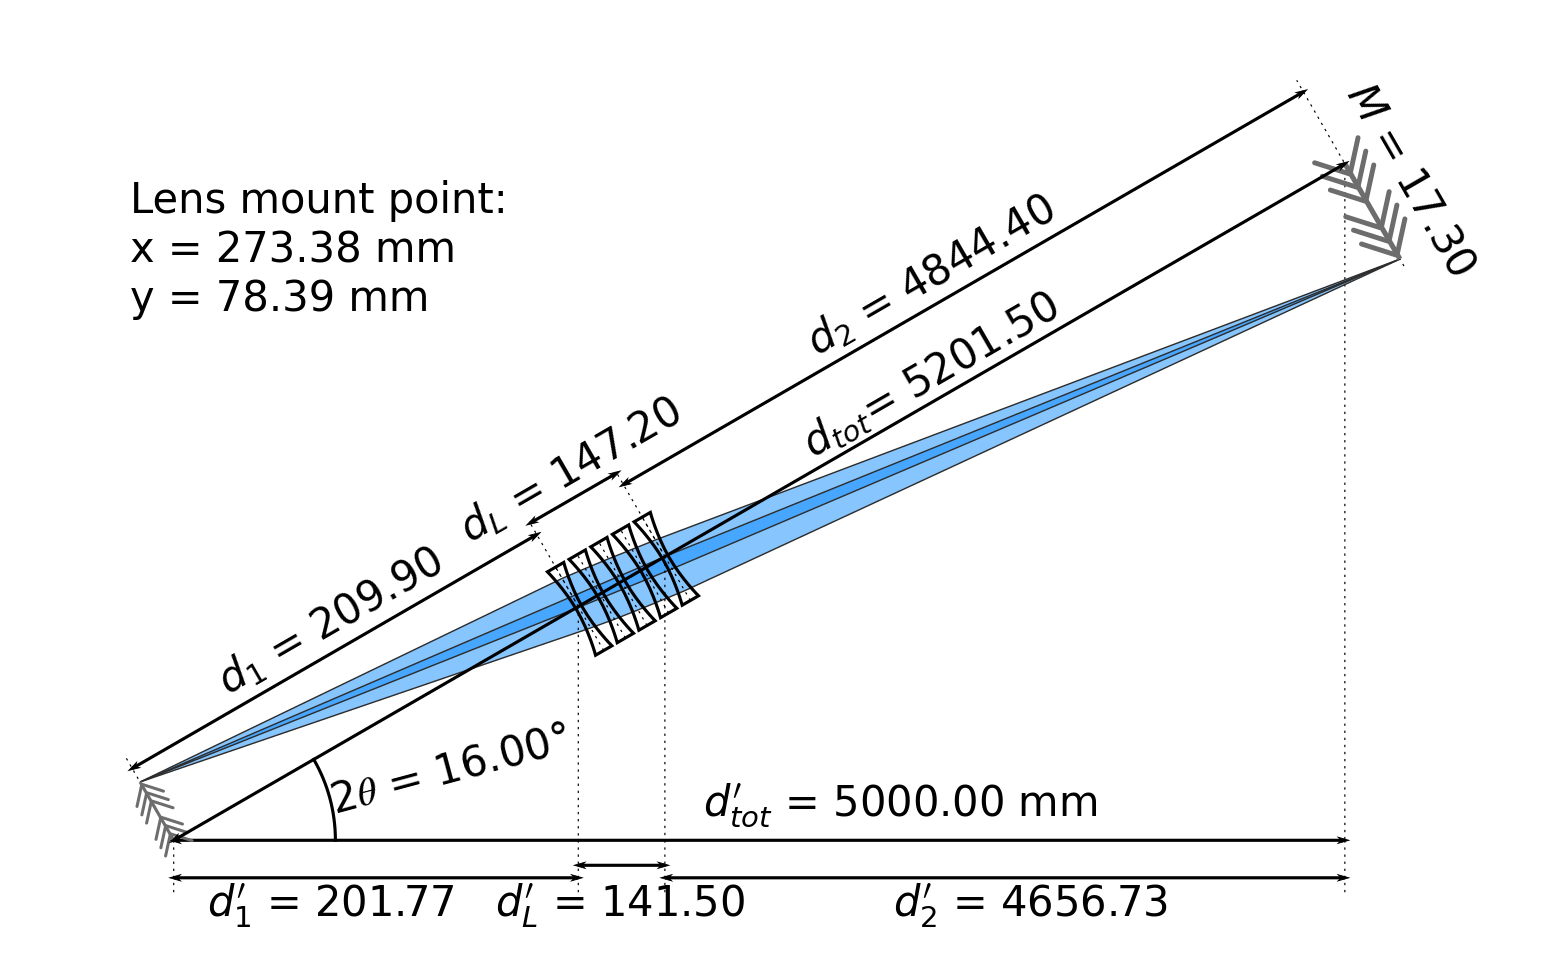

In [17]:
parsed_lens_file = toml.loads(lens_file_contents)
two_theta = 16
d_tot = float(5000)/np.cos(two_theta*np.pi/180)

make_optics_geometry_plot(17, two_theta, d_tot, parsed_lens_file)
print(parsed_lens_file)